### Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt;
import rasterio
from rasterio import features
import rioxarray
import xarray as xr
from pathlib import Path
from stats_functions import summarize_array_values, calculate_zonal_statistics
import datetime as dt

# for this course we use locally stored version of pyemu and flopy to avoid version conflicts
import pyemu
# herebedragons.py contains a series of utility functions that help us manage the tutorial repository
sys.path.insert(0,"..")

In [2]:
# crude but effective: manually define indices that we will use to subset the Reitz AET grids
minx = 3000
maxx = 4500

miny = 0
maxy = 1200

Make copies of the SWB file and run the model. 

In [3]:
# folder containing original model files
org_d = os.path.join('model_master')

# a dir to hold a copy of the original model files
tmp_d = os.path.join('model_copy')

#if os.path.exists(tmp_d):
#    shutil.rmtree(tmp_d)
#shutil.copytree(org_d,tmp_d)

In [4]:
# run SWB in the temporary ('model_copy') directory; run post-processor script(s) to generate model observations
#pyemu.os_utils.run(f"swb2 swb2__control_file.ctl", cwd=tmp_d)
pyemu.os_utils.run(f"python calculate_aet_zonal_stats.py", cwd=tmp_d)

### Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters). SWB is not a code that is supported by FloPy, so we have to roll our own `SpatialReference` based on the SWB2 control file statements.

In [4]:
# SWB model spatial information:
# GRID 620 688 -125045.0 2246285.0 1000.0
# BASE_PROJECTION_DEFINITION +proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23.0 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs

sr = pyemu.helpers.SpatialReference(delr=np.full(620,1000),
                                    delc=np.full(688,1000),
                                    lenuni=2,                # this is a FloPy data definition; means that units are in meter, I think?)
                                    xll=-125045,
                                    yll=2246285,
                                    rotation=0.0,
                                    proj4_str='+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23.0 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs',
                                    length_multiplier=1.0
                                    )

### Instantiate PstFrom

In [5]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("model_template")
start_datetime="1-1-2015"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            #start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=True) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting

2024-09-27 16:31:15.844043 starting: opening PstFrom.log for logging
2024-09-27 16:31:15.844043 starting PstFrom process
2024-09-27 16:31:15.856908 starting: setting up dirs
2024-09-27 16:31:15.857910 starting: removing existing new_d 'model_template'
2024-09-27 16:31:15.867219 finished: removing existing new_d 'model_template' took: 0:00:00.009309
2024-09-27 16:31:15.867219 starting: copying original_d 'model_copy' to new_d 'model_template'
2024-09-27 16:31:17.425787 finished: copying original_d 'model_copy' to new_d 'model_template' took: 0:00:01.558568
2024-09-27 16:31:17.426861 finished: setting up dirs took: 0:00:01.569953


In [6]:
os.listdir(template_ws)

['Active_and_inactive_gridcells.asc',
 'actual_et__2016-01-01_to_2018-12-31__688_by_620.nc',
 'Available_water_content__as_read_in_inches_per_foot.asc',
 'AWS_grid_MN__1000m.asc',
 'AWS_grid_MN__1000m.prj',
 'calculate_aet_zonal_stats.py',
 'Fraction_canopy_cover__as_read_in_unitless.asc',
 'Fraction_pervious_surface__as_read_in_unitless.asc',
 'gross_precipitation__2016-01-01_to_2018-12-31__688_by_620.nc',
 'HSG_grid_MN__1000m.asc',
 'HSG_grid_MN__1000m.prj',
 'Hydrologic_soil_groups__as_read_into_SWB.asc',
 'interception__2016-01-01_to_2018-12-31__688_by_620.nc',
 'Irrigation_mask__as_read_into_SWB.asc',
 'irrigation__2016-01-01_to_2018-12-31__688_by_620.nc',
 'IRR_lookup_MN_v3.txt',
 'Landuse_land_cover__as_read_into_SWB.asc',
 'Latitude__calculated.asc',
 'Longitude__calculated.asc',
 'LU_lookup_MN_v3.txt',
 'Maximum_rooting_depth__as_assembled_from_table__2016-01-01.asc',
 'Minnesota_PRISM_daily_weather__US-Ro6__col_358__row_519__x_232693__y_2415326.tsv',
 'mult',
 'net_infiltrati

In [7]:
# A function that we will use later on in this notebook to munge through observation data
def time_index_from_monthly_filenames(filenames):
    '''helper function to create a pandas DatetimeIndex
       Filename example: AET_2002_03.tif'''
    dates = []
    files = []
    for f in filenames:
        month = str(f.stem).split('_')[2]
        year = str(f.stem).split('_')[1]
        day = 15
        date = dt.date(year=int(year), month=int(month), day=day)
        dates.append(date)
        files.append(str(f))

    dateindex = (pd.DatetimeIndex(dates))
    df = pd.DataFrame({'filename': files, 'date': dates, 'dateindex': dateindex})
    df.sort_values(by=['date'], inplace=True)
    return df

### Observations

#### Simulated values of observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Let's start with the 'simulated_actual_et.csv' file. First load it as a DataFrame to take a look:

In [8]:
df_sim_obs = pd.read_csv(os.path.join(template_ws,"simulated_actual_et.csv"),index_col=0)
df_sim_obs

,zone,mean,max,min,sum,std,var,count,month,year,date,season
1,0,0.811727,0.884853,0.000000,211.049072,0.201232,0.040494,260.0,12,2015,2015-12-01,DJF
2,1,0.887710,0.899901,0.854770,4.438550,0.016821,0.000283,5.0,12,2015,2015-12-01,DJF
3,2,0.856708,0.901139,0.000000,166.201416,0.153849,0.023670,194.0,12,2015,2015-12-01,DJF
4,3,0.888721,0.899706,0.880840,63.099197,0.004137,0.000017,71.0,12,2015,2015-12-01,DJF
5,4,0.891662,0.909581,0.852443,185.465668,0.007128,0.000051,208.0,12,2015,2015-12-01,DJF
...,...,...,...,...,...,...,...,...,...,...,...,...
66,65,0.369949,0.389634,0.000000,173.506149,0.042786,0.001831,469.0,12,2018,2018-12-01,DJF
67,66,0.393418,0.397531,0.391730,23.211647,0.001478,0.000002,59.0,12,2018,2018-12-01,DJF
68,67,0.230841,0.380373,0.000000,349.723663,0.179824,0.032337,1515.0,12,2018,2018-12-01,DJF
69,68,0.397200,0.409473,0.000000,193.039215,0.026048,0.000678,486.0,12,2018,2018-12-01,DJF


The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) _However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset._  This lets the user quickly verify that the `PstFrom` process reproduces the same model output files - an important thing to test!

**You can and should change the observation values later on for the quantities that correspond to actual observation data.**  This is the standard workflow when using `PstFrom` because it allows users to separate the PEST interface setup from the always-important process of setting observation values and weights. We address this part of the workflow in a separate tutorial.

### Observed values (i.e. Pest targets)

Next we need to munge the actual target (i.e. non-modeled) observed values. First, we identify the location of our actual ET grids and the shapefile we wish to use for the zones. The function call makes a dataframe of all of the available actual ET grids at the location we specified.

In [9]:
# point to the location of all of the actual evapotranspiration monthly files;
# obtain a list of all of the files
# create a dataframe of all of the files that we find

reitz_data_path = Path('D:/weather_and_geodata/reitz_2023')
surface_water_basins_shp = 'ALL_BASINS_FOR_OBS_GRID__EPSG_4269.shp'
filenames = reitz_data_path.glob('*.tif')
df = time_index_from_monthly_filenames((filenames))

In [24]:
# here, we further process the dataframe that contains the filenames;
# we use xarray to concatenate all of the various timesteps into a single xarray dataarray for ease of processing
time = xr.Variable('time', df.loc[:,'dateindex'])
#chunks = {'x': 3513, 'y': 3105, 'band': 1}
#da = xr.concat([rioxarray.open_rasterio(f, chunks=chunks, mask_and_scale=True) for f in df.loc[:,'filename']], dim=time).mean(dim='band')
da = xr.concat([rioxarray.open_rasterio(f, mask_and_scale=True) for f in df.loc[:,'filename']], dim=time).mean(dim='band')

reitz_sample_dataset = rioxarray.open_rasterio(df.loc[0,'filename']).squeeze()[miny:maxy,minx:maxx]

In [25]:
da = da * 30.5 / 25.4

##### Calculate seasonal grids from observed data

In [26]:
# now calculate a series of seasonal summed grids for 'DJF', 'MAM', 'JJA', and 'SON'
seasonal_da = da[:,miny:maxy,minx:maxx].resample(time="QS-DEC").reduce(np.sum, dim="time")

In [27]:
# read in the shapefile of zones; convert to format that zonal_stats can handle
surface_water_basins_gdf = gp.read_file(surface_water_basins_shp)

# rasterio is not wired to deal directly with geopandas objects; we must extract the geometry from the geopandas object
# see https://pygis.io/docs/e_raster_rasterize.html
#geom = [shapes for shapes in surface_water_basins_gdf.geometry]
geom = surface_water_basins_gdf[['geometry','BASIN_INDX']].values.tolist()

# rasterize the geometry and index values
zones = features.rasterize(geom, out_shape=reitz_sample_dataset.shape, transform=reitz_sample_dataset.rio.transform(), fill=-9999)

# zonal_stats requires the mask to be a a dataarray; here we create a dataarray with the same dimensions as the seasonal_da,
# copying the values of the mask into the dataarray
zones_da = seasonal_da[0,:,:].copy()
zones_da.data = zones.astype(np.integer)

In [28]:
#make the calculation using our rasterized zone data
df_obs = calculate_zonal_statistics(xarray_dataarray=seasonal_da, mask_dataarray=zones_da, summary_type='quarterly_sum')

# eliminate values that fall outside of our defined zones
df_obs = df_obs.query("zone >= 0")

In [29]:
df_obs

,zone,mean,max,min,sum,std,var,count,month,year,date,season
1,0,0.383683,0.480040,0.313593,173.424789,0.034690,0.001203,452.0,12,2009,2009-12-01,DJF
2,1,0.511092,0.533962,0.480895,4.599831,0.018924,0.000358,9.0,12,2009,2009-12-01,DJF
3,2,0.485107,0.575985,0.433029,158.145004,0.029843,0.000891,326.0,12,2009,2009-12-01,DJF
4,3,0.482571,0.613615,0.429300,59.356255,0.041813,0.001748,123.0,12,2009,2009-12-01,DJF
5,4,0.531919,0.641863,0.432177,183.512115,0.047240,0.002232,345.0,12,2009,2009-12-01,DJF
...,...,...,...,...,...,...,...,...,...,...,...,...
66,65,2.493244,2.655405,2.240460,1929.770752,0.050727,0.002573,774.0,9,2018,2018-09-01,SON
67,66,2.495644,2.753763,2.236382,254.555664,0.101853,0.010374,102.0,9,2018,2018-09-01,SON
68,67,2.538072,3.139568,1.985669,6426.399414,0.158115,0.025000,2532.0,9,2018,2018-09-01,SON
69,68,2.428558,2.739819,2.069122,1928.274902,0.124397,0.015475,794.0,9,2018,2018-09-01,SON


season_sim
DJF    Axes(0.125,0.11;0.62x0.77)
JJA    Axes(0.125,0.11;0.62x0.77)
MAM    Axes(0.125,0.11;0.62x0.77)
SON    Axes(0.125,0.11;0.62x0.77)
dtype: object

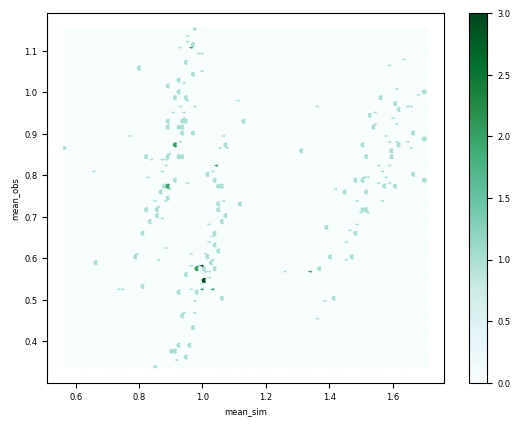

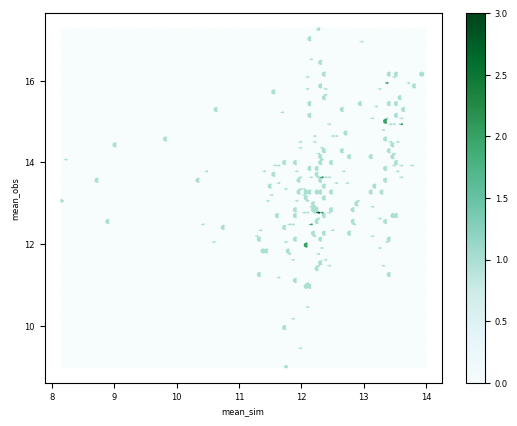

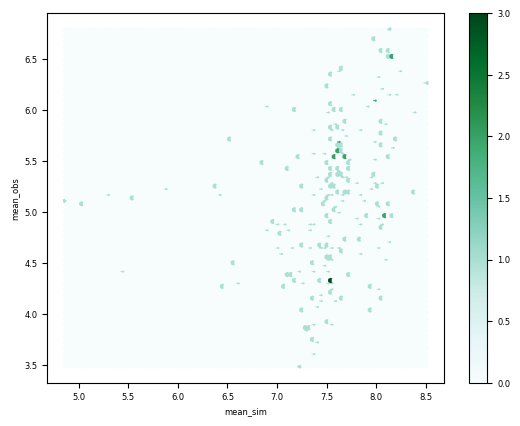

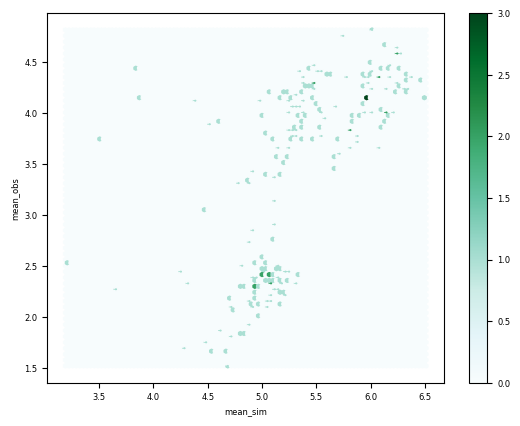

In [33]:
merged_df = df_sim_obs.merge(right=df_obs, left_on=['zone','month','year'], right_on=['zone','month','year'],suffixes=('_sim','_obs'))
merged_df.groupby('season_sim').plot(x='mean_sim',y='mean_obs',kind='hexbin')

#### Adding Observations

First, we will use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method can use ***list-type*** files, where the data are organized in column/tabular format with one or more index columns and one or more data columns.  This method can also use ***array-type*** files, where the data are organized in a 2-D array structure (we will see this one later...)

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column (or columns). Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


# QUESTION: what to do when we don't have observations that perfectly match all of the simulated values?

In [ ]:
aet_df = pf.add_observations("simulated_actual_et.csv", # the model output file to read
                            #insfile="heads.csv.ins",    # optional, the instruction file name
                            index_cols=["zone","year","season"],           #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['mean'],           #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="aet") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these include lots of useful metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [ ]:
aet_df.head()

At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

### Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterization can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Each value in model input files can (1) each be a separate parameter ("grid" scale parameters), (2) be grouped into "zones" or (3) all be treated as a single parameter ("constant" type). Alternatively, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign parameter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the existing/original model input file, or (3) a value which is added to the value in the existing/original model input file. This is very nifty and allows for some pretty advanced parameterization schemes by allowing mixtures of different types of parameters. `PstFrom` is designed to preferentially use parameters setup as multipliers (that is the default parameter type). This lets us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later) so that the multiplicative and additive parameterization process is not something the user has to worry about.


#### Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution (which is what regularization is enforcing!). Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

In [ ]:
# exponential variogram for spatially varying parameters
v_grid = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=2000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_grid, transform='log') 

# plot the gs if you like:
ax = grid_gs.plot()

In [ ]:
# exponential variogram for spatially varying parameters
v_pp = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=15000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
pp_gs = pyemu.geostats.GeoStruct(variograms=v_pp, transform='log') 

# plot the gs if you like:
_ = pp_gs.plot()

In [13]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name.

In [ ]:
tag = "AWS_"
files = [f for f in os.listdir(template_ws) if tag in f and f.endswith(".asc")]
print(files)

Let's setup multiple spatial scales of parameters for AWS. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. 

Each scale of parameters will work with the others as multipliers with the existing AWS arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that allows PEST to move everything at once - that is, change the mean of the entire Kh array. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making everything move. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds (the bounds on the parameters that PEST sees), while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array that MODFLOW reads. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### Array Files

We will first demonstrate step-by-step for `AWS_grid_MN__1000m.asc`
We start by getting the `Active_and_inactive_gridcells.asc` array. As our model has inactive cells, this helps us avoid adding unnecessary parameters. It is also required later when generating pilot points.

In [ ]:
# get the active and inactive gridcells.
active_model_cells_obj = rasterio.open(pf.tpl_d / 'Active_and_inactive_gridcells.asc')
active_model_cells = active_model_cells_obj.read(1)

plt.imshow(active_model_cells)

In [16]:
# f = 'AWS_grid_MN__1000m.asc'

# # grid (fine) scale parameters
# df_gr = pf.add_parameters(f,
#                 mfile_skip=6,
#                 transform='none',
#                 zone_array=active_model_cells, #as we have inactive model cells, we can avoid assigning these as parameters
#                 par_type="pilot-points", #specify the type, these will be unique parameters for each cell
#                 geostruct=grid_gs, # the gestatisical structure for spatial correlation 
#                 par_name_base=f.split('.')[1].replace("_","")+"gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
#                 pargp=f.split('.')[1].replace("_","")+"gr", #likewise for the parameter group name
#                 lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
#                 ult_ubound=3.6, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
#                 )

Remember!  no PEST control file has been made yet. `PstFrom` is simply preparing to make a control file later...

Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information in the form of a dataframe or a point-coverage shapefile. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is set up using a default `pp_space` value of 10 (which is every 10th row and column). You can change this spacing by passing an integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [17]:
## ALERT Stupid code to strip header from Arc ASCII file

line_no = 0

aws_no_header = open(pf.tpl_d / 'AWS_grid_MN__1000m__NO_HEADER.txt', 'w+')

with open(pf.tpl_d / 'AWS_grid_MN__1000m.asc', 'r') as file:
    # Read and print the entire file line by line
    for line in file:
        line_no += 1
        if line_no >  6: 
            aws_no_header.write(line)

aws_no_header.close()

In [ ]:
f = 'AWS_grid_MN__1000m__NO_HEADER.txt'

# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=active_model_cells,
                    par_type="pilotpoints",
                    transform='log',
                    geostruct=pp_gs,
                    par_name_base=f.split('.')[1].replace("_","")+"pp",
                    pargp=f.split('.')[1].replace("_","")+"pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=3.6, ult_lbound=0.01,
                    pp_space=10) # `PstFrom` will generate a unifrom grid of pilot points at specified spacing

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
ax.set_aspect("equal")
ax.pcolormesh(sr.xcentergrid, sr.ycentergrid,active_model_cells)
ax.scatter(df_pp.x,df_pp.y)

Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. In practice, including a single constant parameter for each property can be an important parameter to include since it conceptually represents uncertainty in the mean property value

In [ ]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=active_model_cells,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1].replace("_","")+"cn",
                    pargp=f.split('.')[1].replace("_","")+"cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=3.6, ult_lbound=0.01)

Now we see two template files have been created:

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

Feel free to navigate to the `template_ws` and inspect these files.

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

Damn!  we just parameterized many recognized sources of model input uncertainty at several spatial and temporal scales.  And we expressed spatial and temporal correlation in those parameters.  One last set of parameters that we will need later for sequential data assimilation - initial conditions:

In [ ]:
files = [f for f in os.listdir(template_ws) if "ic_strt" in f and f.endswith(".txt")]
files

In [24]:
for f in files:
    base = f.split(".")[1].replace("_","")
    df = pf.add_parameters(f,par_type="grid",par_style="d",
                      pargp=base,par_name_base=base,upper_bound=50,
                     lower_bound=15,zone_array=ib,transform="none")
    print(df.shape)

### The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

In [ ]:
pst = pf.build_pst()

Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependencies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

That's pretty amazing. But as we just saw, we still need to add commands to actually run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [ ]:
pf.mod_sys_cmds 

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [ ]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

We also need to run MODPATH7, so we need to add that to the list of system commands. In this case we also need to specify the modpath sim file:

In [ ]:
pf.mod_sys_cmds.append("mp7 freyberg_mp.mpsim") #do this only once
pf.mod_sys_cmds

OK, now let's re-build the Pst control file and check out the changes to the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [ ]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

#### Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported through the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will demonstrate this to post-process model observations after each run.

Now let's see this py-sauce in action: we are going to add a little post-processing function to extract the final simulated water level for all model cells for the last stress period from the MF6 binary headsave file and save them to ASCII format so that PEST(++) can read them with instruction files.  And, while we are at it, let's also extract the global water budget info from the MF6 listing file and store it in dataframes - these are usually good numbers to watch!  We will need the simulated water level arrays later for sequential data assimilation (wouldn't it be nice if MF6 supported the writing of ASCII format head arrays?).  Anyway, this function is stored in the "helpers.py" script which you can find in the tutorial folder.

In [ ]:
pst.observation_data

In [ ]:
pf.add_py_function("helpers.py","extract_hds_arrays_and_list_dfs()",is_pre_cmd=False)

That last argument - `is_pre_cmd` tells `PstFrom` if the python function should be treated as a pre-processor or a post-processor. So we have added that post-processor, but we still need to setup pest observations for those ASCII head arrays.  Let's do that by first calling that function to operate once within the `template_ws` to generate the arrays and then we can add them with `add_observations()`:  

In [ ]:
import helpers
helpers.test_extract_hds_arrays(template_ws)

In [ ]:
files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]
files

In [ ]:
for f in files:
    pf.add_observations(f,prefix=f.split(".")[0],obsgp=f.split(".")[0])

In [ ]:
for f in ["inc.csv","cum.csv"]:
    df = pd.read_csv(os.path.join(template_ws,f),index_col=0)
    pf.add_observations(f,index_cols=["totim"],use_cols=list(df.columns.values),
                        prefix=f.split('.')[0],obsgp=f.split(".")[0])

Crushed it!

#### Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) This is not standard `pyemu` functionality, but we provide it here as an example of incorporating custom code for observation processing. The sky's the limit! It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain the temporal-differences between head and SFR observations. The new .csv files are named `heads.tdiff.csv`and `sfr.tdiff.csv`, respectively.

First, let's load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see several new csv files. These are the new secondary observations calculated by the post-processing function.

In [ ]:
# run the helper function
helpers.process_secondary_obs(ws=template_ws)

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

OK, so now let's add this function to the `forward_run.py` script.

In [ ]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [ ]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

Remember to re-build the Pst control file:

In [ ]:
pst = pf.build_pst()

In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

Now we see that `extract_hds_array_and_list_dfs()` has been added to the forward run script and it is being called after MF6 runs. 

In [ ]:
obs = pst.observation_data
obs

### After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc.

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observations from custom *.ins files,  observation weights, parameter group INCTYP's and forecasts.

We will do so now.

#### Add Observations from INS files

Recall that we wish to include observations of particle end time and status. As mentioned earlier, MP7 output files are not ina nicely organized tabular format - so we need to construct a custom instruction file. We will do this now:

In [ ]:
# write a really simple instruction file to read the MODPATH end point file
out_file = "freyberg_mp.mpend"
ins_file = out_file + ".ins"
with open(os.path.join(template_ws, ins_file),'w') as f:
    f.write("pif ~\n")
    f.write("l7 w w w w !part_status! w w !part_time!\n")

Now add these observations to the `Pst`:

In [ ]:
pst.add_observations(ins_file=os.path.join(template_ws, ins_file),
                    out_file=os.path.join(template_ws, out_file),
                            pst_path='.')

# and then check what changed                            
obs = pst.observation_data
obs.loc[obs.obsnme=='part_status', 'obgnme'] = 'part'
obs.loc[obs.obsnme=='part_time', 'obgnme'] = 'part'

obs.iloc[-2:]

#### Parameters with Zero as Intial Value

Recall that we assigned additive parameters to the GHB heads. Our initial parameter values for these parameter types were set as 0 (zero). This creates a wee bit of trouble when calculating derivatives - this is only an issue for algorithms that use finite-difference derivatives. There are a couple of ways we could get around it. One way is to add an "offset" to the parameter initial values and to the parameter bounds. Another is to use "absolute" increment types (INCTYP). See the PEST manual or PEST++ user guides for descriptions of increment types. 

We will apply both here. 

We will assign INCTYP as 'absolute'. We will leave DERINC as 0.01 (the default). It is a reasonable value in this case.

In [ ]:
head_pargps = [i for i in pst.adj_par_groups if 'head' in i]
head_pargps

In [ ]:
pst.parameter_groups.loc[head_pargps, 'inctyp'] = 'absolute'

Now add the "offset" to parameter data entries:

In [ ]:
par = pst.parameter_data
par_names = par.loc[par.parval1==0].parnme

par.loc[par_names].head()

In [ ]:
offset = -10
par.loc[par_names, 'offset'] = offset
par.loc[par_names, ['parval1', 'parlbnd', 'parubnd']] -= offset

par.loc[par_names].head()

#### Forecasts

For most models there is a forecast/prediction that someone needs. Rather than waiting until the end of the project, the forecast should be entered into your thinking and workflow __right at the beginning__.  Here we do this explicitly by monitoring the forecasts as "observations" in the control file.  This way, for every PEST(++) analysis we do, we can watch what is happening to the forecasts - #winning

The optional PEST++ `++forecasts` control variable allows us to provide the names of one or more observations featured in the "observation data" section of the PEST control file; these are treated as predictions in FOSM predictive uncertainty analysis by PESTPP-GLM. It is also a convenient way to keep track of "forecast" observations (makes post-processing a wee bit easier later on).

Recall that, for our synthetic case we are interested in forecasting:

 - groundwater level in the upper layer at row 9 and column 1 (site named "trgw-0-9-1") in stress period 22 (time=640);
 - the "tailwater" surface-water/groundwater exchange during stress period 13 (time=367); and
 - the "headwater" surface-water/groundwater exchange at stress period 22 (time=640).
 - the particle travel time.


In [ ]:
forecasts =[
            'oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
            'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
            'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
            'part_time'
            ]

forecasts

In [ ]:
fobs = obs.loc[forecasts,:]
fobs

We will just set this optional pest++ argument because it will trigger certain automatic behavior later in PESTPP-GLM

In [ ]:
pst.pestpp_options['forecasts'] = forecasts

### Re-write the Control File!

Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [ ]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'),version=2)

So that was pretty epic. We now have a (very) high-dimensional PEST interface that includes secondary observations, as well as forecasts, ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [ ]:
pst.control_data.noptmax

OK, so when we run PEST it will call the model once and then stop. If the next cell is successful, then everything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [ ]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

Recall that we assigned observation values generated from the "base model run"? If we setup everything correctly, this means that PEST should have obtained residuals very close to zero. As mentioned, this is a good way to check for problems early on.

Let's check the Phi recorded in the *.iobj file (could also check the *.rec or *.rei files).

In [ ]:
# read the file
iobj = pd.read_csv(os.path.join(template_ws, 'freyberg_mf6.iobj'))

# check value in phi column
iobj.total_phi

 Sweet! Zero. All is well.

### Prior Parameter Covariance Matrix

One the major reasons `PstFrom` was built is to help with building the Prior - both covariance matrix and ensemble - with geostatistical correlation.  Remember all that business above related to geostatistical structures and correlations?  This is where it pays off.

Let's see how this works.  For cases with less than about 30,000 parameters, we can actually generate and visualize the prior parameter covariance matrix.  If you have more parameters, this matrix may not fit in memory.  But, not to worry, `PstFrom` has some trickery to help generate the geostatistical prior ensemble even in cases where the number of parameters is greater than 30,000. 


In [ ]:
# build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
# depending on your machine, this may take a while...
if pf.pst.npar < 35000:  #if you have more than about 35K pars, the cov matrix becomes hard to handle
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    # and take a peek at a slice of the matrix
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[:1000,:1000])
    except:
        pass

snap!  That big block must be a grid-scale parameter group...

In [ ]:
cov.row_names[:10]

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials. Note: you do not have to call `build_prior()` before calling `draw()`!

In [ ]:
pe = pf.draw(num_reals=1000, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) #writes the paramter ensemble to binary file
assert pe.shape[1] == pst.npar

Let's now test-run one of these geostatistical realizations (always a good idea!).  We do this by replacing the `parval1` values in the control with a row from `pe`:

In [ ]:
pst.parameter_data.loc[:,"parval1"] = pe.loc[pe.index[0],pst.par_names].values
pst.parameter_data.parval1.values

In [ ]:
pst.control_data.noptmax = 0
pst.write(os.path.join(template_ws,"test.pst"),version=2)
pyemu.os_utils.run("pestpp-glm test.pst",cwd=template_ws)

If all went well, that's it! The PEST-interface is setup, tested and we have our prior prepared. We should be good to go!

### Bonus: Understanding Multiplier-Parameters

Now the multiplier files in the `template_ws/mult` folder and the MF6 input files in the `template_ws` folder contain the values corresponding to this realization, so we can visualize the multiplier parameter process:

In [ ]:
df = pd.read_csv(os.path.join(template_ws,"mult2model_info.csv"))
kh1_df = df.loc[df.model_file.str.contains("npf_k_layer1"),:]
kh1_df

In [ ]:
org_arr = np.loadtxt(os.path.join(template_ws,kh1_df.org_file.iloc[0]))
inp_arr = np.loadtxt(os.path.join(template_ws,kh1_df.model_file.iloc[0]))
mlt_arrs = [np.loadtxt(os.path.join(template_ws,afile)) for afile in kh1_df.mlt_file]
arrs = [org_arr]
arrs.extend(mlt_arrs)
arrs.append(inp_arr)
names = ["org"]
names.extend([mf.split('.')[0].split('_')[-1] for mf in kh1_df.mlt_file])
names.append("MF6 input")
fig,axes = plt.subplots(1,kh1_df.shape[0]+2,figsize=(5*kh1_df.shape[0]+2,5))
for i,ax in enumerate(axes.flatten()):
    arr = np.log10(arrs[i])
    arr[ib==0] = np.NaN
    cb = ax.imshow(arr)
    plt.colorbar(cb,ax=ax)
    ax.set_title(names[i],loc="left")
plt.tight_layout()    
    

So now we can see the difference the pilot point geostructure makes compared to the grid-scale geostructure.  The pilot point array has a much stronger spatial correlation (over a larger distance) than the grid-scale...

# Finally, what's up with all these new files and folders? We can trace through them to see how multipliers are applied

In [ ]:
from IPython.display import Image, display
display(Image(url='./pest_flow2.gif'))